## Лабораторная работа 5. Часть 2.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from scipy.special import expit

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("dark")
sns.set(font_scale=1.6)

## Задача 1

Реализуйте логистическую регрессию с $\ell_2$ регуляризацией для поиска оценки параметров с помощью стохастического mini-batch градиентного спуска (SGD).

In [13]:
class LogisticRegression():
    '''
    Модель логистической регрессии. Имеет следующие гиперпараметры:

    :param alpha: параметр регуляризации. 
                  Если равно 0, то регуляризация не происходит.
    :param lr: константа, на которую домножаем градиент при обучении
    :param max_iter: ограничение на кол-во итераций
    :param fit_intercept: указывает, следует ли добавить константу в признаки
    '''

    def __init__(self, alpha=0, lr=0.5, max_iter=1e5,
                 fit_intercept=True):
        '''Создает модель и инициализирует параметры.'''

        self.alpha = alpha
        self.lr = lr
        self.max_iter = max_iter
        self.fit_intercept = fit_intercept

    @staticmethod
    def _sigmoid(x):
        import scipy
        
        return scipy.special.expit(x)

    def _add_intercept(self, X): # Почему-то Ваша реализация у еня работала не правильно. X_copy была совсем не похожа на X,
        # поэтому я изменил код. Благодаря этому выросло качество, а также получились нормальные результаты в задании с выбором
        # наилучшего lr (до этого было lr = 100, что очень странно)
        '''
        Добавляем свободный коэффициент к нашей модели. 
        Это происходит путем добавления вектора из 1 к исходной матрице.

        :param X: исходная матрица признаков
        :return: матрица X с добавленным свободным коэффициентов
        '''

        X_copy = np.hstack((X, np.ones(X.shape[0]).reshape(-1,1)))
        # X_copy = np.full((X.shape[0], X.shape[1] + 1), fill_value=1)
        # X_copy[:, :-1] = X

        return X_copy

    def fit(self, X, Y):
        '''
        Обучает модель логистической регресии с помощью SGD,
        пока не выполнится self.max_iter итераций.

        :param X: матрица признаков
        :param Y: истинные метки
        '''

        assert X.shape[0] == Y.shape[0]

        if self.fit_intercept:  # добавляем свободный коэфициент
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()
            
        step = 0
        self.batch_size = 64 # установим батч size
        self.weights = np.random.normal(0, 1, (X_copy.shape[1]))
        while step < self.max_iter:
            # разбиваем на батчи
            batch_indices = np.random.choice(X_copy.shape[0], size=self.batch_size, replace=False)
            batch = X_copy[batch_indices]
            
            grad_w = (1 / self.batch_size) * batch.T.dot(Y[batch_indices] - self._sigmoid(batch.dot(self.weights.T))) # считаем градиент
            for_regularization = self.weights
            if self.fit_intercept:
                for_regularization[-1] = 0  # так как мы не регуляризуем свободный член
            # print(self.weights)
            self.weights = self.weights + self.lr * (grad_w - 2 * self.alpha * for_regularization) # делаем шаг SGD
            step += 1

        self.coef_ = self.weights[:-1]  # коэффициенты модели
        self.intercept_ = self.weights[-1]  # свободный коэффициент
        # self.weights состоит из коэффициентов модели и свободного члена
        return self

    def predict(self, X):
        '''
        Применяет обученную модель к данным 
        и возвращает точечное предсказание (оценку класса).

        :param X: матрица признаков
        :return: предсказание с размерностью (n_test, )
        '''

        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == self.weights.shape[0]

        predictions = np.sign(X_copy.dot(np.append(self.coef_, self.intercept_).T))
        predictions[predictions == -1] = 0

        return predictions

    def predict_proba(self, X):
        '''
        Применяет обученную модель к данным
        и возвращает предсказание вероятности классов 0 и 1.

        :param X: матрица признаков
        :return: вероятности предсказания с размерностью (n_test, 2)
        '''

        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == self.weights.shape[0]
        
        prob_predictions = np.array([])
        plus = self._sigmoid(X_copy.dot(np.append(self.coef_,self.intercept_).T))
        minus = self._sigmoid(-X_copy.dot(np.append(self.coef_,self.intercept_).T))
        prob_predictions = np.vstack((plus, minus)).T

        return prob_predictions

In [17]:
a = np.array([1,2,3,4])
b = np.array([3,4,5,7])
c = np.array([])
c = np.vstack((a,b))
c.T

array([[1, 3],
       [2, 4],
       [3, 5],
       [4, 7]])

In [18]:
c.T.shape

(4, 2)

Рассмотрим игрушечный датасет на $30$ признаков `load_breast_cancer` из библиотеки `sklearn`. Это относительно простой для бинарной классификации датасет по диагностике рака молочной железы.

Ради интереса можно прочитать описание признаков.

In [3]:
dataset = load_breast_cancer()
dataset['DESCR'].split('\n')[11:31]

['    :Attribute Information:',
 '        - radius (mean of distances from center to points on the perimeter)',
 '        - texture (standard deviation of gray-scale values)',
 '        - perimeter',
 '        - area',
 '        - smoothness (local variation in radius lengths)',
 '        - compactness (perimeter^2 / area - 1.0)',
 '        - concavity (severity of concave portions of the contour)',
 '        - concave points (number of concave portions of the contour)',
 '        - symmetry',
 '        - fractal dimension ("coastline approximation" - 1)',
 '',
 '        The mean, standard error, and "worst" or largest (mean of the three',
 '        worst/largest values) of these features were computed for each image,',
 '        resulting in 30 features.  For instance, field 0 is Mean Radius, field',
 '        10 is Radius SE, field 20 is Worst Radius.',
 '',
 '        - class:',
 '                - WDBC-Malignant',
 '                - WDBC-Benign']

Разделим нашу выборку на обучающую и тестовую:

In [4]:
X, Y = dataset['data'], dataset['target']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((455, 30), (114, 30), (455,), (114,))

In [5]:
X_DataFrame = pd.DataFrame(dataset['data'], columns = dataset['feature_names'])
X_DataFrame

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [6]:
X_train

array([[9.029e+00, 1.733e+01, 5.879e+01, ..., 1.750e-01, 4.228e-01,
        1.175e-01],
       [2.109e+01, 2.657e+01, 1.427e+02, ..., 2.903e-01, 4.098e-01,
        1.284e-01],
       [9.173e+00, 1.386e+01, 5.920e+01, ..., 5.087e-02, 3.282e-01,
        8.490e-02],
       ...,
       [1.429e+01, 1.682e+01, 9.030e+01, ..., 3.333e-02, 2.458e-01,
        6.120e-02],
       [1.398e+01, 1.962e+01, 9.112e+01, ..., 1.827e-01, 3.179e-01,
        1.055e-01],
       [1.218e+01, 2.052e+01, 7.722e+01, ..., 7.431e-02, 2.694e-01,
        6.878e-02]])

In [7]:
Y_train

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,

При использовании регуляризации данные необходимо нормализовать. Воспользуемся для этого классом `StandardScaler` из библиотеки `sklearn`. 

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[-1.44075296, -0.43531947, -1.36208497, ...,  0.9320124 ,
         2.09724217,  1.88645014],
       [ 1.97409619,  1.73302577,  2.09167167, ...,  2.6989469 ,
         1.89116053,  2.49783848],
       [-1.39998202, -1.24962228, -1.34520926, ..., -0.97023893,
         0.59760192,  0.0578942 ],
       ...,
       [ 0.04880192, -0.55500086, -0.06512547, ..., -1.23903365,
        -0.70863864, -1.27145475],
       [-0.03896885,  0.10207345, -0.03137406, ...,  1.05001236,
         0.43432185,  1.21336207],
       [-0.54860557,  0.31327591, -0.60350155, ..., -0.61102866,
        -0.3345212 , -0.84628745]])

## Задание 2 из части 1

Строим совместные распределения вещественных признаков и целевой переменной 

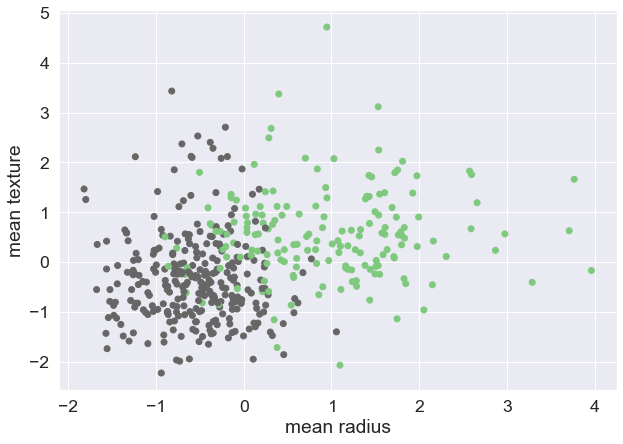

In [9]:
plt.figure(figsize = (10, 7))
plt.scatter(X_train[:, 0], X_train[:, 1], c = Y_train, cmap='Accent')
plt.xlabel(dataset['feature_names'][0])
plt.ylabel(dataset['feature_names'][1])
plt.show()

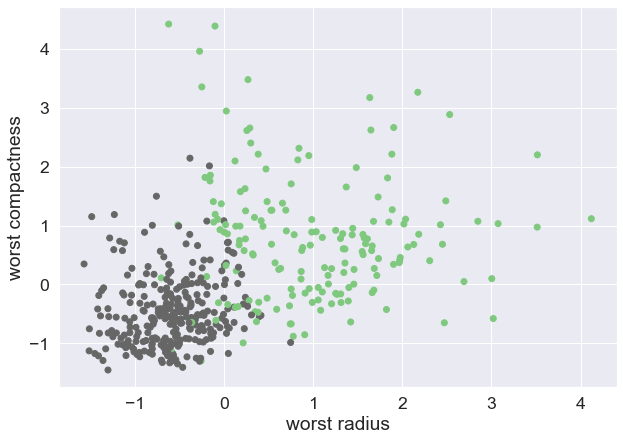

In [10]:
plt.figure(figsize = (10, 7))
plt.scatter(X_train[:, 20], X_train[:, 25], c = Y_train, cmap='Accent')
plt.xlabel(dataset['feature_names'][20])
plt.ylabel(dataset['feature_names'][25])
plt.show()

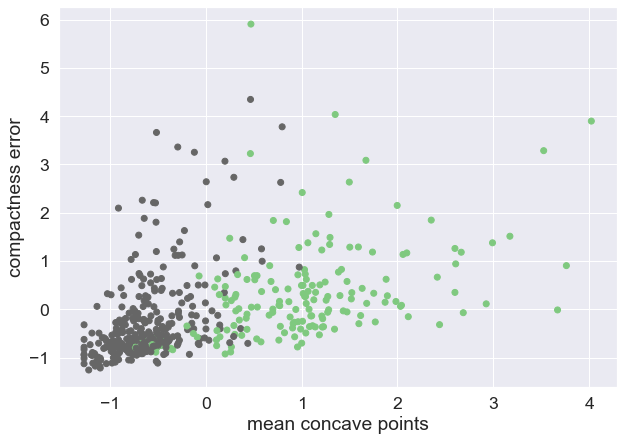

In [11]:
plt.figure(figsize = (10, 7))
plt.scatter(X_train[:, 7], X_train[:, 15], c = Y_train, cmap='Accent')
plt.xlabel(dataset['feature_names'][7])
plt.ylabel(dataset['feature_names'][15])
plt.show()

Заметим, что везде (я строил много распределний, просто оставил три, чтобы не захламлять ноутбук) наша выборка не линейно разделима, но мы можем провести прямую, которая будет довольно неплохо разделять объекты на классы. Таким образом, скорее всего мы не сможем подогнаться как-то идеально с помощью линейной модели (хотя может в многомерии у нас там все и хорошо разделяется). Однако можно точно сказать, что какие бы два признака мы не взяли, мы не можем разделить объекты идеально с помощью прямой, поэтому будем пробовать обучать на всех данных. Там уже у нас все будет 30-тимерное, больше шанс, что сможем как-нибудь хорошо разделить гиперплоскостью.

Теперь обучите модель логистической регрессии.

In [28]:
clf = LogisticRegression()
clf.fit(X_train, Y_train)

На занятии обсуждали, что в нашей постановке задачи при сравнении выиграет модель с меньшим FN, ведь каждая не обнаруженная опухоль может стоить человеческой жизни. Чем меньше ложно отрицательных срабатываний, тем выше Recall модели, а значит разумно взять Recall в качестве целевой метрики. 

Построить модель с Recall = 1 довольно просто (Как?), но в ней не будет большого смысла, т.к., например, для нашей задачи отправление на доп. обследование может стоить дополнительных средств и времени специалистов, поэтому хотелось, чтобы наша модель имела неплохую точность. Какую метрику можно использовать, чтобы учесть и точность, и полноту?

**Построить модель с Recall = 1 можно так: просто всем объектам присвоим класс 1, тогда FN = 0 и Recall = TP / TP = 1**

**Чтобы учесть и точность, и полноту, надо смотреть на F меру**

Выберите и посчитайте целевые метрики для нашей задачи.

In [15]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, fbeta_score, roc_curve, precision_recall_curve, auc, 
    average_precision_score
)

In [16]:
accuracy = accuracy_score(Y_test, clf.predict(X_test))
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.921


In [17]:
precision = precision_score(Y_test, clf.predict(X_test))
print(f'Precision = {precision:.3f}')

Precision = 0.970


In [18]:
# То есть если мы видим положительный класс, то с вероятностью 0.97 есть рак

In [19]:
recall = recall_score(Y_test, clf.predict(X_test))
print(f'Recall = {recall:.3f}')

Recall = 0.901


In [20]:
# То есть из всех больных раком мы обнаружим 90%

In [21]:
f1 = f1_score(Y_test, clf.predict(X_test))
print(f'F1 = {f1:.3f}')

F1 = 0.934


In [29]:
# Посмотрим еще на F_beta с beta = 3 (то есть нам важнее recall)
fbeta = fbeta_score(Y_test, clf.predict(X_test), beta=3)
print(f'FBeta-score (beta=2): {fbeta:.3f}')

FBeta-score (beta=2): 0.908


Рассмотрите как влияет размер шага (`learning rate`) на качество модели. Обучите каждую модель одинаковое число итераций (например, 10000), а затем посчитайте качество. Сделайте выводы.

Будем смотреть на F_beta для beta = 3

In [23]:
lrs = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 5, 10]

In [24]:
scores = []
for lr in lrs:
    clf = LogisticRegression(lr = lr, max_iter = 10000)
    clf.fit(X_train, Y_train)
    fbeta = fbeta_score(Y_test, clf.predict(X_test), beta=3)
    scores.append(fbeta)
scores

[0.20289855072463767,
 0.7417974322396576,
 0.9322033898305084,
 0.9985935302390998,
 0.9859154929577466,
 0.9732016925246826,
 0.9732016925246826,
 0.9732016925246826,
 0.9732016925246826,
 0.9590973201692524,
 0.9335219236209336,
 0.9078014184397164,
 0.9078014184397164]

Лучшее качество при lr = 1e-2. Так происходит, так как при маленьком шаге мы не успеваем сойтись, а при больших шагах мы не можем прийти точно в минимум, так как в конце мы все время через него перепрыгиваем.

Рассмотрите несколько моделей, в которых установите не менее 5-ти различных коэффициентов регуляризации, а также модель без регуляризатора. Сравните, влияет ли наличие регуляризации на качество, сделайте выводы. Под качеством подразумевается значение какой-либо выбранной вами метрики качества классификации.

In [32]:
alphas = [0, 1, 3, 5, 10]
scores = []
for a in alphas:
    clf = LogisticRegression(lr = 1e-2, alpha = a)
    clf.fit(X_train, Y_train)
    fbeta = fbeta_score(Y_test, clf.predict(X_test), beta=3)
    scores.append(fbeta)
scores

[0.9845288326300984,
 0.9732016925246826,
 0.9732016925246826,
 0.9718309859154931,
 0.9718309859154931]

Видим, что регуляризация не сильно влияет на качестве, но при этом даже в отрицательную сторону. То есть чем выше мы выставляем alpha, тем меньше score. Видимо, переобучения особо нет, коэффициенты не слишком большие и регуляризовать особо нечего. Возможно, нам повезло с разделением на тест и трейн, они получились похожими.

Выберите объект из тестовой выборки и постройте для него доверительный интервал для предсказания вероятности. Какие условия нужно проверить? 

In [66]:
clf = LogisticRegression(lr = 1e-2, alpha = 0)
clf.fit(X_train, Y_train)

In [94]:
clf.predict_proba(X_test)[1]

array([7.67435759e-09, 9.99999992e-01])

In [95]:
clf.predict(X_test)[1]

0.0

То есть мы взяли второй объект, и для него вероятность, что он принадлежит классу 0 почти 100%

На лекции было, что для использования хороших свойств и построения доверительных интервалов нужно, чтобы логит был линеен (Строим ядерную регрессию и берем от нее логит. Приближение логита должно быть похоже на линию)
Ну тут есть небольшая проблема - у нас не два признака, поэтому глазами не посмотришь.

Линеаризация ожидаемого отклика $g(z) = ln \frac{z}{1-z}$, то есть $g^{-1}(z) = \frac{e^{-z}}{1+e^{-z}}$

In [51]:
def g_inverse(z):
    return np.e ** (-z) / (1 + np.e ** (-z))

Информационная матрица Фишера I для логистической регресии:

In [40]:
(X_train @ clf.coef_.T + clf.intercept_).shape

(455,)

In [42]:
import scipy

In [63]:
I = X_train.T @ np.diag(scipy.special.expit(X_train @ clf.coef_.T + clf.intercept_) * 
                        (1 - scipy.special.expit(X_train @ clf.coef_.T + clf.intercept_))) @ X_train

In [45]:
I.shape

(30, 30)

Для нормального распределения вероятность попадания x в интервал $[\mu - 2\sigma, \mu + 2\sigma]$ равна 95%. У нас $\mu = 0, \sigma = 1$, следовательно итервал $[-2,2]$. Для $\alpha = 95$% имеем квантиль 1,645 (из таблиц)

In [109]:
# Тогда delta из лекций равна:
d = 1.645 * np.sqrt(X_test[1] @ (I ** (-1)) @ X_test[1].T)
d

19.554301414501275

In [110]:
# Тогда доверительный интервал:
left = g_inverse(X_test[1] @ clf.coef_.T + clf.intercept_ + d)
right = g_inverse(X_test[1] @ clf.coef_.T + clf.intercept_ - d)

In [111]:
print("[" + str(left) + ", " + str(right) + "]")

[0.29547904110726014, 1.0]


In [ ]:
# Вот такой интервал вышел